# Inspect Memmap Patches

This notebook loads a few training crops from the memmap dataset so you can verify
which channels are used (HH, HV, incidence angle) and whether labels look correct.
It reads the same preprocessed files that the training pipeline uses.

In [1]:
import json
import random
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# Resolve repo root
repo_root = Path.cwd()
if not (repo_root / 'src').exists():
    repo_root = repo_root.parent

sys.path.insert(0, str(repo_root / 'src'))

try:
    from dataset import INPUT_CHANNELS, CLASS_NAMES, IGNORE_INDEX
except Exception:
    INPUT_CHANNELS = ['nersc_sar_primary', 'nersc_sar_secondary', 'sar_incidenceangle']
    CLASS_NAMES = [
        'OpenWater', 'NewIce', 'YoungIce',
        'ThinFirstYearIce', 'ThickFirstYearIce', 'OldIce'
    ]
    IGNORE_INDEX = -100

data_dir = repo_root / 'data' / 'ai4arctic_hugging face'
memmap_dir = data_dir / 'npy_memmap'
assert memmap_dir.exists(), f'Missing memmap dir: {memmap_dir}'

print('Repo:', repo_root)
print('Memmap:', memmap_dir)
print('Channels:', INPUT_CHANNELS)
print('Classes:', CLASS_NAMES)

Repo: /home/mike1/Arcticv2
Memmap: /home/mike1/Arcticv2/data/ai4arctic_hugging face/npy_memmap
Channels: ['nersc_sar_primary', 'nersc_sar_secondary', 'sar_incidenceangle']
Classes: ['OpenWater', 'NewIce', 'YoungIce', 'ThinFirstYearIce', 'ThickFirstYearIce', 'OldIce']


In [2]:
meta_path = memmap_dir / 'metadata.json'
stats_path = memmap_dir / 'normalization_stats.json'

meta = json.loads(meta_path.read_text()) if meta_path.exists() else {}
stats = json.loads(stats_path.read_text()) if stats_path.exists() else {}

crop_size = meta.get('crop_size', 512)
split_strategy = meta.get('split_strategy', 'unknown')
mean = np.array(stats.get('mean', [0.0, 0.0, 0.0]), dtype=np.float32)
std = np.array(stats.get('std', [1.0, 1.0, 1.0]), dtype=np.float32)

print('Crop size:', crop_size)
print('Split strategy:', split_strategy)
print('Mean:', mean.tolist())
print('Std:', std.tolist())

Crop size: 512
Split strategy: region
Mean: [-0.13354626297950745, -0.19230887293815613, -0.07911176234483719]
Std: [0.7163852453231812, 0.4533175230026245, 0.6984074711799622]


In [3]:
coords_data = np.load(memmap_dir / 'train_coords.npy', allow_pickle=True).item()
coords = coords_data['coords']
scene_names = coords_data['scene_names']
classes_per_crop = coords_data.get('classes', None)

print('Total crops:', len(coords))
print('Total scenes:', len(scene_names))

if classes_per_crop is not None:
    class_crop_counts = [0] * len(CLASS_NAMES)
    for classes in classes_per_crop:
        for c in classes:
            if 0 <= c < len(class_crop_counts):
                class_crop_counts[c] += 1
    print('Crops containing each class:')
    for i, name in enumerate(CLASS_NAMES):
        print(f'  {i} {name}: {class_crop_counts[i]}')

Total crops: 84652
Total scenes: 445
Crops containing each class:
  0 OpenWater: 56843
  1 NewIce: 3821
  2 YoungIce: 3851
  3 ThinFirstYearIce: 3470
  4 ThickFirstYearIce: 19869
  5 OldIce: 14679


In [4]:
PALETTE = np.array([
    [0, 0, 139],      # OpenWater
    [173, 216, 230],  # NewIce
    [144, 238, 144],  # YoungIce
    [255, 255, 0],    # ThinFirstYearIce
    [255, 165, 0],    # ThickFirstYearIce
    [255, 255, 255],  # OldIce
], dtype=np.float32) / 255.0
IGNORE_COLOR = np.array([0.5, 0.5, 0.5], dtype=np.float32)

def load_patch(idx, split='train'):
    scene_idx, r, c = coords[idx]
    scene_name = scene_names[scene_idx]
    scene_dir = memmap_dir / split
    image_path = scene_dir / f'{scene_name}_image.npy'
    label_path = scene_dir / f'{scene_name}_label.npy'
    image_mmap = np.load(image_path, mmap_mode='r')
    label_mmap = np.load(label_path, mmap_mode='r')
    image = image_mmap[:, r:r+crop_size, c:c+crop_size]
    label = label_mmap[r:r+crop_size, c:c+crop_size]
    return image, label, scene_name, (int(r), int(c))

def colorize_label(label):
    rgb = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.float32)
    for c in range(len(CLASS_NAMES)):
        mask = label == c
        if mask.any():
            rgb[mask] = PALETTE[c]
    rgb[label == 255] = IGNORE_COLOR
    return rgb

def show_patch(idx, normalize=False):
    image, label, scene_name, (r, c) = load_patch(idx)
    if normalize:
        image = (image.astype(np.float32) - mean[:, None, None]) / (std[:, None, None] + 1e-8)

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    titles = ['HH', 'HV', 'Incidence', 'SOD Label']

    for i in range(3):
        vmin = np.nanpercentile(image[i], 1)
        vmax = np.nanpercentile(image[i], 99)
        axes[i].imshow(image[i], cmap='gray' if i < 2 else 'viridis', vmin=vmin, vmax=vmax)
        axes[i].set_title(titles[i])
        axes[i].axis('off')

    label_rgb = colorize_label(label)
    axes[3].imshow(label_rgb)
    axes[3].set_title(titles[3])
    axes[3].axis('off')

    unique = np.unique(label)
    class_list = None
    if classes_per_crop is not None:
        class_list = classes_per_crop[idx]

    title = f'{scene_name} r={r} c={c} | unique={unique.tolist()}'
    if class_list is not None:
        title += f' | classes={sorted(class_list)}'
    fig.suptitle(title, fontsize=10)
    plt.tight_layout()
    plt.show()

/home/mike1/Arcticv2/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:132: RuntimeWarning: overflow encountered in cast
  'get_virtual_index': lambda n, quantiles: (n - 1) * quantiles,
/home/mike1/Arcticv2/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4687: RuntimeWarning: overflow encountered in cast
  indexes_above_bounds = virtual_indexes >= valid_values_count - 1
/home/mike1/Arcticv2/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4593: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = add(a, diff_b_a * t, out=... if out is None else out)
/home/mike1/Arcticv2/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4594: RuntimeWarning: invalid value encountered in scalar multiply
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


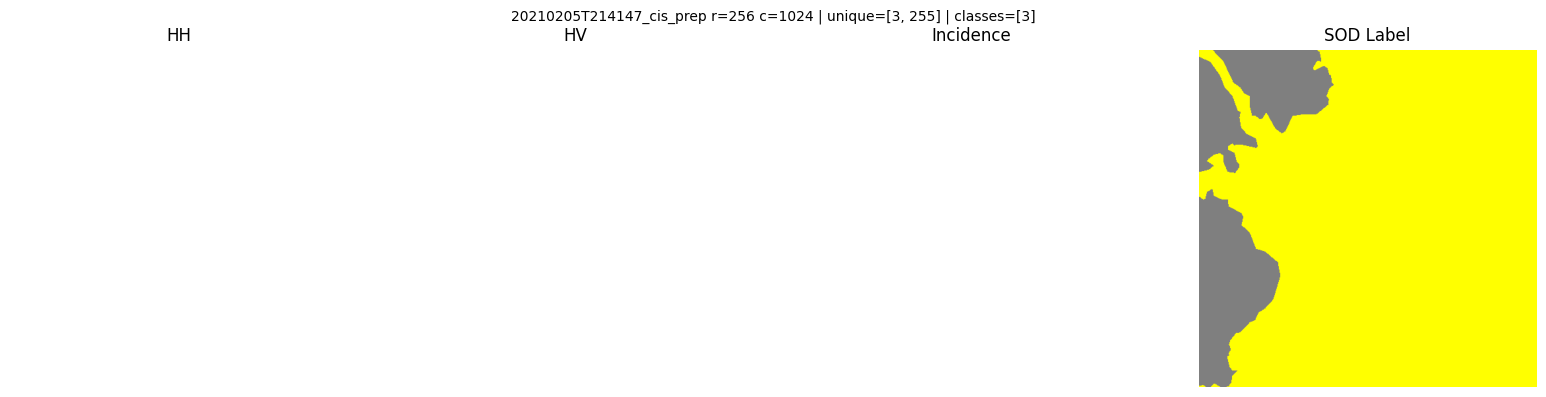

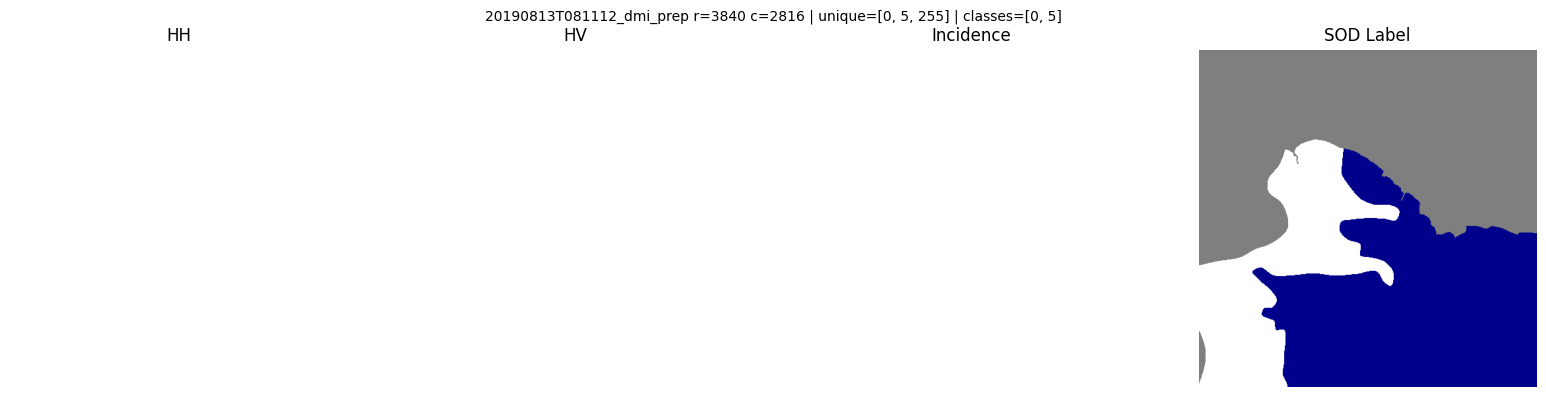

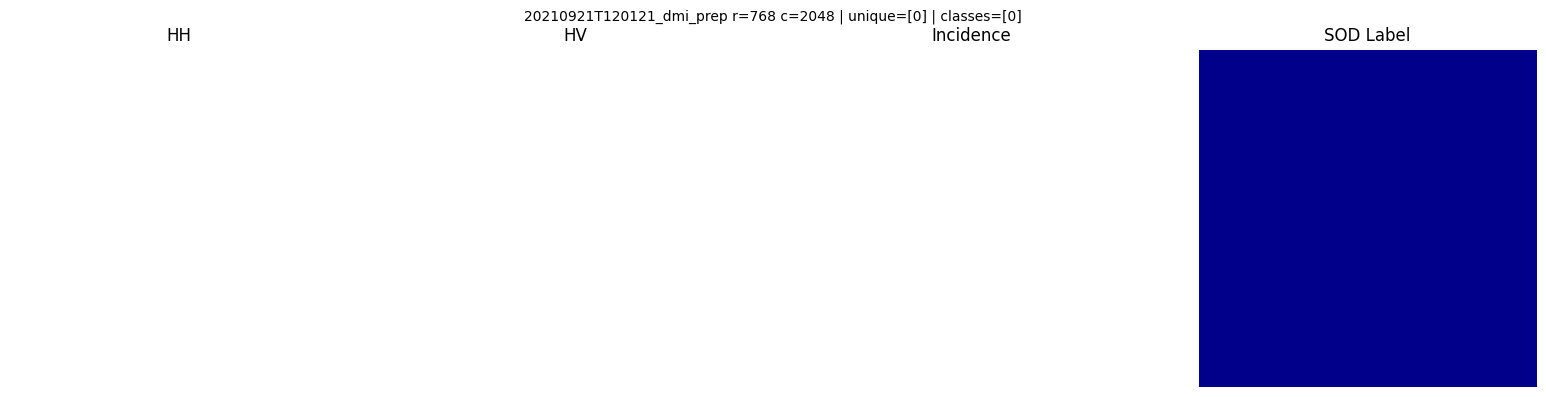

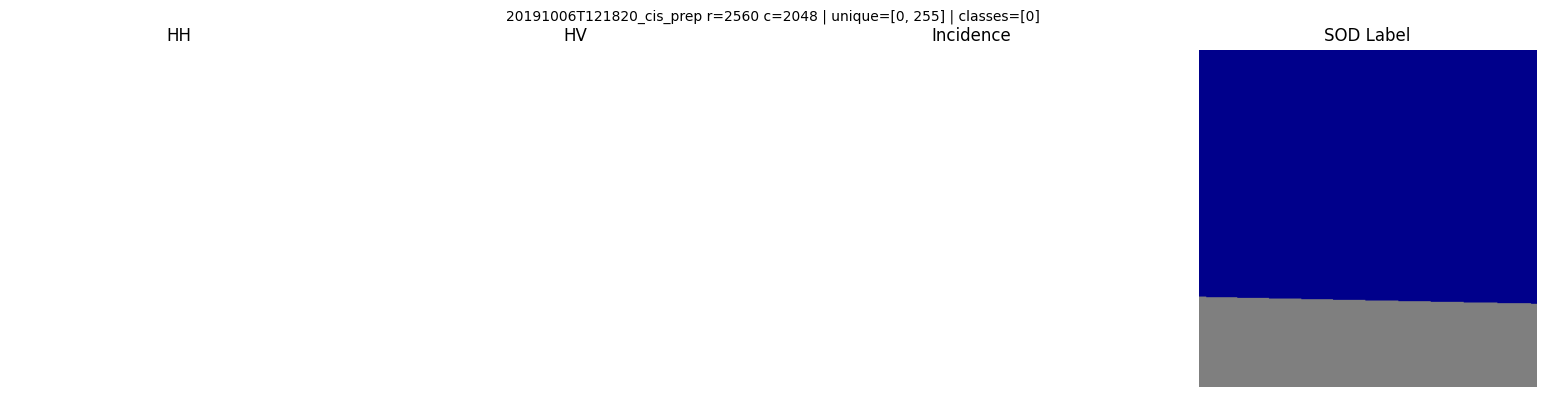

In [5]:
# Show a few random patches
random.seed(0)
sample_indices = random.sample(range(len(coords)), 4)
for idx in sample_indices:
    show_patch(idx, normalize=False)

Patch with class 5 idx: 57502


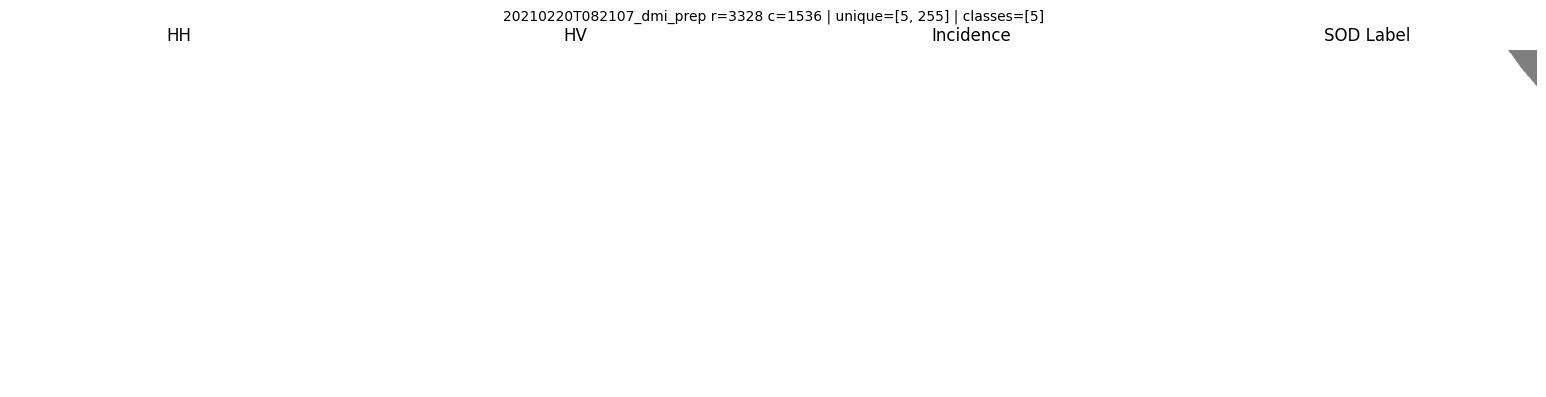

In [6]:
def find_patch_with_class(target_class):
    if classes_per_crop is None:
        return None
    indices = [i for i, classes in enumerate(classes_per_crop) if target_class in classes]
    if not indices:
        return None
    return random.choice(indices)

target_class = 5  # OldIce
idx = find_patch_with_class(target_class)
print('Patch with class', target_class, 'idx:', idx)
if idx is not None:
    show_patch(idx, normalize=False)